<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/optimization_practice/Maintenance_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maintenance Planning

* [Problem Statement][1]

[1]:https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/04.04-Maintenance-Planning.ipynb

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

!python -m pip install gurobipy

from pyomo.environ import *
from pyomo.gdp import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.4 MB/s eta 0:00:00


## Situation 1

* Disjunctions are 2 binaries

### NOTES
* It seems that different solver can get different optimization results 🤨

In [24]:
np.random.seed(10)

# problem parameters
T = 90        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k:np.random.uniform() for k in range(1, T+1)}
print(c)


# Plot function refered from https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/04.04-Maintenance-Planning.ipynb
def plot_schedule(model):
    fig,ax = plt.subplots(3,1, figsize=(9,4))
    
    ax[0].bar(model.T, [model.c[t] for t in model.T], color='g')
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(model.T, [model.work[t]() for t in model.T], label='normal operation', color='g')
    ax[1].set_title('unit operating schedule $x_t$')
    
    ax[2].bar(model.MT, [model.maintain[t]() for t in model.MT], color='g')
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(model.T)+0.9)
        
    plt.tight_layout()

{1: 0.771320643266746, 2: 0.0207519493594015, 3: 0.6336482349262754, 4: 0.7488038825386119, 5: 0.4985070123025904, 6: 0.22479664553084766, 7: 0.19806286475962398, 8: 0.7605307121989587, 9: 0.16911083656253545, 10: 0.08833981417401027, 11: 0.6853598183677972, 12: 0.9533933461949365, 13: 0.003948266327914451, 14: 0.5121922633857766, 15: 0.8126209616521135, 16: 0.6125260668293881, 17: 0.7217553174317995, 18: 0.29187606817063316, 19: 0.9177741225129434, 20: 0.7145757833976906, 21: 0.5425443680112613, 22: 0.14217004760152696, 23: 0.3733407600514692, 24: 0.6741336150663453, 25: 0.4418331744229961, 26: 0.4340139933332937, 27: 0.6177669784693172, 28: 0.5131382425543909, 29: 0.6503971819314672, 30: 0.6010389534045444, 31: 0.8052231968327465, 32: 0.5216471523936341, 33: 0.9086488808086682, 34: 0.3192360889885453, 35: 0.09045934927090737, 36: 0.30070005663620336, 37: 0.11398436186354977, 38: 0.8286813263076767, 39: 0.04689631938924976, 40: 0.6262871483113925, 41: 0.5475861559192435, 42: 0.8192869

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 43.63319787
  Upper bound: 43.63319787
  Number of objectives: 1
  Number of constraints: 88
  Number of variables: 88
  Number of binary variables: 180
  Number of integer variables: 180
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Bra

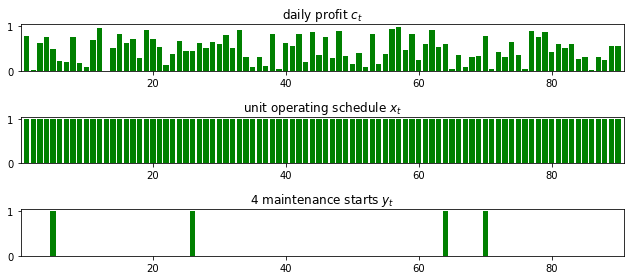

In [32]:
model = ConcreteModel()

model.T = RangeSet(1, T)
model.MT = RangeSet(1, T-M+1)
model.N = RangeSet(0, M-1)

model.c = Param(model.T, initialize=c)

model.work = Var(model.T, domain=Binary)  # indicate whether on date t will work
model.maintain = Var(model.T, domain=Binary)  # indicate the whether date t is the first maintenance date

model.Obj = Objective(expr=sum(model.c[t] * model.work[t] for t in model.T), sense=maximize)

model.c1 = Constraint(expr=sum(model.maintain[t] for t in model.MT) == P)  # total number of maintenance is P
model.c2 = Constraint(model.MT, rule=lambda model, t: sum(model.maintain[t+n] for n in model.N) <= 1) # Within each maintenance period, there's only 1 maintenace happen
model.c3 = Disjunction(model.MT, rule=lambda model, t: [model.maintain[t]==0, sum(model.work[t+n] for n in model.N)==0])


SolverFactory('cbc').solve(model).write()
print(f'Max Profit is: {model.Obj()}')
plot_schedule(model)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1061
  Lower bound: 41.43043374700336
  Upper bound: 41.43043374700338
  Number of objectives: 1
  Number of constraints: 1322
  Number of variables: 973
  Number of binary variables: 356
  Number of integer variables: 356
  Number of continuous variables: 617
  Number of nonzeros: 3081
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

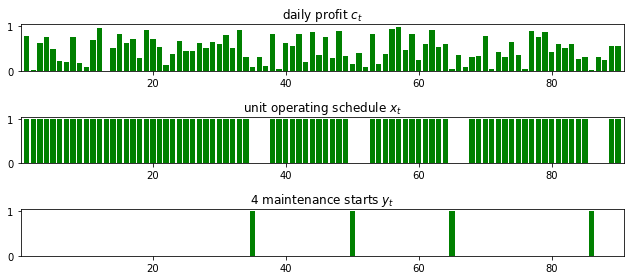

In [31]:
TransformationFactory('gdp.hull').apply_to(model)
SolverFactory('gurobi').solve(model).write()
print(f'Max Profit is: {model.Obj()}')
plot_schedule(model)